# Running GROMACS on AQE for Polymer Simulation

This notebook will demonstrate the pipeline of calculating glass transition temperature $(T_g)$ using GROMACS molecular dynamics software.

- [x] We need to load an AiiDA profile. The `load_profile` method will load the default profile if no explicit profile name is specified.

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='854b62c634cd4cd6ade4c630f3c0af0e' name='gromacs'>

#Delete this shell. (No USE -- )
%aiida
%verdi status

We need to set some user defined parameters which will be used throughout the pipeline

In [41]:
# Polymer/Monomer inputs
# monomer_pdbfilename = ''                        # PDB filename of the monomer
# monomer_count_per_polymer = 50                  # Number of monomers present in one polymer
polymer_pdbfilename = '14tPBSingleChain.pdb'    # PDB filename of the polymer
polymer_count = 50                              # Number of polymer in the simulation box

# MD simulation inputs
thermo_T = 300.15                               # Simulation Temperature (K)
thermo_P = 1.0                                  # Simulation Pressure (bar)

Two types of input data is required from the user.
1. Polymer input/Monomoer input - User will provide the name of the polymer and the number of polymers they want to use in molecular dynamics simulation inorder to optimize the computational cost with highest efficacy.
(**_NOTE:_** Once the polymerization step is introduced, the polymer input will be replaced by the monomer inputs.)

2. MD simulation inputs - User will provide an absolute thermodynamic condition for the simulation (i.e. temperature and pressure) or a range of temperature and pressure at which simulation will be conducted.

**_NOTE:_** A minimum intervention will be required after this.

Necessary python packages are imported.

In [3]:
import pathlib
import os

from aiida import engine, orm
from aiida_shell import launch_shell_job

Convert the user input into `aiida.orm` `Data` types accepted by the `node` arguments. 

In [4]:
polymer_pdbfilename = orm.Str(polymer_pdbfilename)
polymer_count = orm.Int(polymer_count)

thermo_T = orm.Float(thermo_T)
thermo_P = orm.Float(thermo_P)

- [ ] Polymerization step

We are opening the file and wrap it in AiiDA's `SinglefileData` data type, which allows it to be stored in the provenance graph.

In [5]:
polymer = orm.SinglefileData(os.getcwd() + '/' + polymer_pdbfilename.value)

The `gmx pdb2gmx` is the first GROMACS command to create th topology file according to the forcefield information for the polymer.

In [6]:
@engine.calcfunction
def calc_molecular_weight_polymer(polymer: orm.SinglefileData) -> orm.Float:
    import pandas as pd
    elecsvfile = os.getcwd() + '/elements.csv'
    dataframe_elements = pd.read_csv(elecsvfile, index_col = None)
    
    lines = polymer.get_content().split('\n')
    ele_lines = [line for line in lines if line.startswith('ATOM') or line.startswith('HETATM')]

    # Calculate molecular weight
    molecular_weight_polymer = 0.0
    for line in ele_lines:
        # Find element and atomic mass from the periodic table
        elestr = line[12:14]

        if elestr[0] == ' ':
            if elestr[1].isalpha() and elestr[1].isupper():
                ele = elestr[1]
            else:
                ele = ' '
        elif elestr[0].isdigit():
            if elestr[1].isalpha() and elestr[1].isupper():
                ele = elestr[1]
            else:
                ele = ' '
        elif elestr[0].isalpha() and elestr[0].isupper():
            if elestr[1].isdigit():
                ele = elestr[0]
            else:
                ele = elestr
        else:
            ele = ' '

        try:
            molecular_weight_polymer += float(dataframe_elements.loc[dataframe_elements['Symbol'] == ele, 'AtomicMass'].iloc[0])
        except:
            raise Exception(f'ERROR: Atom type of {elestr} not found.')

    return orm.Float(molecular_weight_polymer)

@engine.calcfunction
def calc_simulation_box_length(molecular_weight_polymer: orm.Float, polymer_count: orm.Int) -> orm.Float:
    molecular_weight = molecular_weight_polymer.value * polymer_count.value
    
    # Default density (0.4 g/cm3)
    density = 0.4
    avogadro_number = 6.022e23  # molecules/mol
    cm_to_nm = 1e7  # cm to nm conversion factor
    
    # Step 1: Mass of one molecule
    mass_per_molecule = molecular_weight / avogadro_number  # g
    
    # Step 2: Volume of cubic box
    volume = mass_per_molecule / density  # cm³
    
    # Step 3: Side length of the cubic box
    box_length = volume**(1/3)  # cm
    box_length = box_length * cm_to_nm  # nm

    return orm.Float(box_length)

molecular_weight_polymer = calc_molecular_weight_polymer(polymer)
box_length = calc_simulation_box_length(molecular_weight_polymer, polymer_count)

We are setting the force-field folder and wrap it in AiiDA's `FolderData` data type, which allows it to be stored in the provenance graph.

In [7]:
# Default Parameters
ffdir = os.getcwd() + '/oplsaa.ff'
oplsaa = orm.FolderData(tree=ffdir)                       

In [8]:
# Run `gmx pdb2gmx` to convert the PDB to GROMACS .gro format.
results_pdb2gmx, node_pdb2gmx = launch_shell_job(
    'gmx',
    arguments='pdb2gmx -f {polymer} -o polymer_out.pdb -water spce -ff oplsaa',
    nodes={
        'polymer': polymer,
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['polymer_out.pdb', 'topol.top', 'posre.itp'],
    metadata={'options': {'redirect_stderr': True}},
)
print(results_pdb2gmx['stdout'].get_content())

                  :-) GROMACS - gmx pdb2gmx, 2023.3-spack (-:

Executable:   /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2/bin/gmx_mpi
Data prefix:  /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2
Working dir:  /anfhome/aamir/scratch/aiida/9f/84/13d6-b178-4e10-b9ff-e3dde09d4563
Command line:
  gmx_mpi pdb2gmx -f 14tPBSingleChain.pdb -o polymer_out.pdb -water spce -ff oplsaa

Force field 'oplsaa' occurs in 2 places. pdb2gmx is using the one in the current directory. Use interactive selection (not the -ff option) if you would prefer a different one.
Force field 'oplsaa' occurs in 2 places. pdb2gmx is using the one in the current directory. Use interactive selection (n

<div class="alert alert-info">
`gmx` is the GROMACS executable which will be executed with several parameters. The `nodes` argument takes a dictionary of `SinglefileData` and `FolderData` which will be copied to the working directory where the `gmx` command is executed. The `oplsaa` in `nodes` are copied to the `oplsaa.ff` folder in the working directory. If the key of the node appears as a placeholder in the `arguments` argument, it is replaced with its filename. 
</div>

The `gmx pdb2gmx` is expected to generate three outputs of interest:
- `polymer_out.pdb`: `.pdb` file of the polymer.
- `topol.top`: The topology file.
- `posre.itp`: The position restraint file included in the topology file.

<div class="alert alert-info">
These output files will be used in the upcoming steps in the pipeline. To capture these output files in the AiiDA's provenance graph, these filenames are declared in the `output` argunent. `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

Similar to the previous steps, GROMACS creates a simulation box where mutiple chains of the polymer will be inserted for the MD simulations. From the previous step, `.pdb` file of the single polymer chain is used to replicate the polymer chain inside the simulation box. In the output, we get a simulation box containing `polymer_count` number of polymers.

In [9]:
@engine.calcfunction
def check_insert_molecules(log: orm.SinglefileData, polymer_count: orm.Int) -> orm.Bool:
    lines = log.get_content().split('\n')
    check_lines = [line for line in lines if line.startswith('Added')]
    
    if len(check_lines) > 1:
        raise Exception('ERROR: Multiple lines got selected in the check_lines variable', check_lines)

    wordlist = check_lines[0].split()
    polymer_count_inserted = orm.Int(wordlist[1])
    
    if polymer_count_inserted.value == polymer_count.value:
        return orm.Bool(False)
    else:
        return orm.Bool(True)

run = orm.Bool(True)
while run.value:
    results_insert, node_insert = launch_shell_job(
        'gmx',
        arguments='insert-molecules -box {box_length} -ci {polymer} -nmol {polymer_count} -try 999 -o melt.pdb',
        nodes={
            'box_length': box_length,
            'polymer': polymer,
            'polymer_count': polymer_count,
        },
        outputs=['melt.pdb'],
        metadata={'options': {'redirect_stderr': True}},
    )
    print(results_insert['stdout'].get_content())
    run = check_insert_molecules(results_insert['stdout'], polymer_count)
    print(run.value)
    if run.value:
        
        run = orm.Bool(False)
    else:
        run = orm.Bool(False)
    print(run.value)

              :-) GROMACS - gmx insert-molecules, 2023.3-spack (-:

Executable:   /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2/bin/gmx_mpi
Data prefix:  /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2
Working dir:  /anfhome/aamir/scratch/aiida/7a/df/b074-d007-46bc-a700-8a1390ea2fdb
Command line:
  gmx_mpi insert-molecules -box 8.2514028455544 -ci 14tPBSingleChain.pdb -nmol 50 -try 999 -o melt.pdb

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom ty

While running the `pdb2gmx` command we have created the topology for one single polymer chain. However, in the `topol.top` file we have to provide the number of polymer chain present in the simulation box. Therefore, we are updating the number of molecules line from 1 to `polymer_count` using the `sed` command.

In [10]:
results_updatetop, node_updatetop = launch_shell_job(
    'sed',
    arguments='-i "s/Other               1/Other               23/g" {top}',
    nodes={
        'top': results_pdb2gmx['topol_top'],
    },
    outputs=['topol.top'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_updatetop['stdout'].get_content())

<div class="alert alert-info">
The output `topol.top` file is declared in the `output` argunent where `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

**Prerequisite for MD simulations and simulation box preparation is completed and we can proceed to run the molecular dynamics simulation.**

In [11]:
em_mdp = orm.SinglefileData.from_string(
    """
    integrator      = steep
    emtol           = 1000.0
    emstep          = 0.01
    nsteps          = 50000
    nstlist         = 1
    cutoff-scheme   = Verlet
    ns_type         = grid
    coulombtype     = PME
    rcoulomb        = 1.0
    rvdw            = 1.0
    pbc             = xyz
    ld_seed         = 1
    gen_seed        = 1
    """,
    filename='em.mdp',
)

# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_em, node_grompp_em = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o output.tpr',
    nodes={
        'mdp': em_mdp,
        'gro': results_insert['melt_pdb'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['output.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_em['stdout'].get_content())

The `gmx grompp` takes the input of three necesary files to generate the `.tpr` file.
- [x] `.mdp`: The molecular dynamics parameters.
- [x] `.gro`: The coordinate information of all the polymer chains present in the simulation box.
- [x] `.top`: The tolology file of the polymer. Also, this has the information of number of polymers present in the simulation box.

The generated `.tpr` file is used for running the molecular dynamics simulation. We can run the `gmx mdrun` to run the energy minimization step.

In [17]:
# Run `gmx mdrun` to run the energy minimization.
results_em, node_em = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_em['output_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log'],
    metadata={'options': {'redirect_stderr': True}},
)
print(results_em['stdout'].get_content())

                   :-) GROMACS - gmx mdrun, 2023.3-spack (-:

Executable:   /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2/bin/gmx_mpi
Data prefix:  /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2
Working dir:  /anfhome/aamir/scratch/aiida/01/6e/5946-56d5-4125-93f8-bf1c22da8889
Command line:
  gmx_mpi mdrun -v -deffnm output -s output.tpr

Reading file output.tpr, VERSION 2023.3-spack (single precision)
Using 1 MPI process

Non-default thread affinity set, disabling internal thread affinity

Using 8 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000
Step=    0, Dmax= 1.0e-02 nm, Epot=  2.45157e+04 Fmax= 1.37

Similar to the previous `gmx grompp` step, we can proceed with NPT equilibration step where the molecular dynamics simulation will be performed at the given thermodynamic conditions given by the user.

In [18]:
eqnpt_mdp = orm.SinglefileData.from_string(
    """
    title                   = NPT Equilibration
    ;define                 = -DPOSRES
    integrator              = md
    dt                      = 0.002
    nsteps                  = 50000
    nstenergy               = 2000
    nstxout-compressed      = 10000
    nstvout                 = 0
    nstlog                  = 1000
    gen_vel                 = yes
    gen_temp                = 298.15
    pbc                     = xyz
    cutoff-scheme           = Verlet
    rlist                   = 1.0
    ns_type                 = grid
    nstlist                 = 10
    coulombtype             = PME
    fourierspacing          = 0.12
    pme_order               = 4
    rcoulomb                = 1.0
    vdwtype                 = Cut-Off
    rvdw                    = 1.0
    DispCorr                = EnerPres
    constraints             = h-bonds
    constraint_algorithm    = lincs
    lincs_iter              = 1
    lincs_order             = 4
    tcoupl                  = v-rescale
    tc-grps                 = System
    ref_t                   = 298.15
    tau_t                   = 0.1
    pcoupl                  = c-rescale
    pcoupltype              = isotropic
    ref_p                   = 1.0
    tau_p                   = 2.0
    ;refcoord-scaling        = com
    compressibility         = 4.5e-5
    """,
    filename='eqnpt.mdp',
)

# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o npt.tpr',
    nodes={
        'mdp': eqnpt_mdp,
        'gro': results_em['output_gro'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['npt.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
print(results_grompp_eqnpt['stdout'].get_content())

                   :-) GROMACS - gmx grompp, 2023.3-spack (-:

Executable:   /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2/bin/gmx_mpi
Data prefix:  /anfhome/spack/opt/spack/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placehold/linux-almalinux8-zen3/aocc-4.1.0/gromacs-2023.3-upt5rsow4zsttzs63kqercg7her4e3e2
Working dir:  /anfhome/aamir/scratch/aiida/f2/3c/3948-9c6d-42b8-91dc-1c8b8c4afd25
Command line:
  gmx_mpi grompp -f eqnpt.mdp -c output.gro -p topol.top -o npt.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Setting the LD random seed to -604112979

Generated 362526 of the 362526 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 362526 of the 362526 1-4 parameter combinations

Excluding 3 bonded neighbours 

The generated `.tpr` file is used for running the molecular dynamics simulation for NPT equilibration. We can run the `gmx mdrun` to run the NPT equilibration step.

In [20]:
# Run `gmx mdrun` to run the energy minimization.
results_eqnpt, node_eqnpt = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_eqnpt['npt_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log', 'output.xtc'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_eqnpt['stdout'].get_content())

**MD simulation is completed. Therefore, we can go for analysis of the simulated system.**

<div class="alert alert-info">
Using `gmx energy` command we can calculate and plot the primary properties for the simulated polymer system.
</div>

In [21]:
# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o potential.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': orm.SinglefileData.from_string('10\n0'),
    },
    outputs=['potential.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

<div class="alert alert-info">
The input for `gmx energy` is the `output.edr` from the `results_eqnpt`. Here we first pass `10` which corresponds to the potential energy, followed by `0` which finalizes the selection and completes the prompt. The `output` file of this step saved as GROMACS generated `.xvg` format.
</div>

To visualize the data, first we need to import necessary python packages to be installed.

In [22]:
import io

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, IFrame

We define the `create_plot` function and pass the `potential.xvg` from the previous step. The `create_plot` will create a plot which is saved to a stream in memory which is then passed to a `SinglefileData` node to store it in AiiDA's provecance graph.

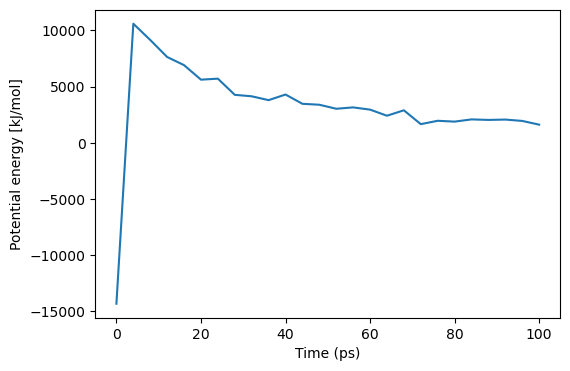

In [23]:
@engine.calcfunction
def create_plot(xvg: orm.SinglefileData) -> orm.SinglefileData:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    plt.figure(figsize=(6,4))
    plt.plot(*data)
    plt.xlabel('Time (ps)')
    plt.ylabel('Potential energy [kJ/mol]')
    stream = io.BytesIO()
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=150)
    #stream.seek(0)
    return orm.SinglefileData(stream, filename='potential.png')
    
# Create a plot from the extracted potential energy of the system
plot = create_plot(results_energy['potential_xvg'])

In the same way we can get the density data from the `output.edr` using the `gmx energy` command and plot it.

In [24]:
# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o density.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': orm.SinglefileData.from_string('22\n0'),
    },
    outputs=['density.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

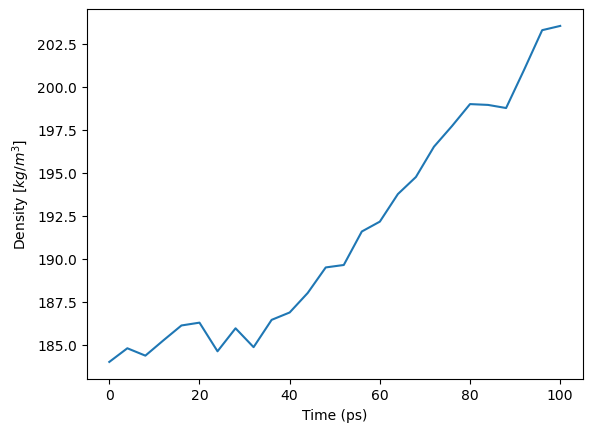

In [25]:
@engine.calcfunction
def create_plot(xvg: orm.SinglefileData) -> orm.SinglefileData:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    plt.plot(*data)
    plt.xlabel('Time (ps)')
    plt.ylabel('Density $[kg/m^3]$')
    stream = io.BytesIO()
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=300)
    #stream.seek(0)
    return orm.SinglefileData(stream, filename='density.png')

# Create a plot from the extracted density of the system
plot = create_plot(results_energy['density_xvg'])

In [42]:
thermo_T_count = 5
thermo_T_list = orm.ArrayData(np.array([thermo_T-10.0, thermo_T-5.0]))

In [43]:
from aiida.engine.daemon.client import get_daemon_client

client = get_daemon_client()
client.start_daemon()

In [45]:
@engine.calcfunction
def set_mdp_parameter(id: int=0, thermo_T: np.float64=298.15, thermo_P: np.float64=1.0, ) -> orm.SinglefileData:
    mdp_str = f"""
    title                   = NPT Equilibration
    ;define                 = -DPOSRES
    integrator              = md
    dt                      = 0.002
    nsteps                  = 50000
    nstenergy               = 2000
    nstxout-compressed      = 10000
    nstvout                 = 0
    nstlog                  = 1000
    gen_vel                 = yes
    gen_temp                = 298.15
    pbc                     = xyz
    cutoff-scheme           = Verlet
    rlist                   = 1.0
    ns_type                 = grid
    nstlist                 = 10
    coulombtype             = PME
    fourierspacing          = 0.12
    pme_order               = 4
    rcoulomb                = 1.0
    vdwtype                 = Cut-Off
    rvdw                    = 1.0
    DispCorr                = EnerPres
    constraints             = h-bonds
    constraint_algorithm    = lincs
    lincs_iter              = 1
    lincs_order             = 4
    tcoupl                  = v-rescale
    tc-grps                 = System
    ref_t                   = {thermo_T.value}
    tau_t                   = 0.1
    pcoupl                  = c-rescale
    pcoupltype              = isotropic
    ref_p                   = {thermo_P.value}
    tau_p                   = 2.0
    ;refcoord-scaling        = com
    compressibility         = 4.5e-5
    """

    #print(mdp_str)
    #print('T = ', thermo_T.value)
    #print('P = ', thermo_P.value)

    return orm.SinglefileData.from_string(mdp_str, filename=f'eqnpt-{id.value}.mdp')

nodelist = []
resultslist = []

for i, thermo_T_ele in enumerate(thermo_T_list.get_array()):
    print(i, thermo_T_ele, type(thermo_T_ele), type(i))
    eqnpt_mdp = set_mdp_parameter(i, thermo_T_ele, thermo_P)
    print(eqnpt_mdp.filename)
    #print(eqnpt_mdp.get_content())

    print(i)
    tpr = f'npt-{i}.tpr'
    results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
        'gmx',
        arguments='grompp -f {mdp} -c {gro} -p {top} -o {tpr}',
        nodes={
            'mdp': eqnpt_mdp,
            'gro': results_em['output_gro'],
            'top': results_updatetop['topol_top'],
            'tpr': orm.Str(tpr),
            'folder': oplsaa,
        },
        filenames={
            'folder': 'oplsaa.ff'
        },
        outputs=[tpr],
        metadata={'options': {'redirect_stderr': True}},
    )
    nodelist.append(node_grompp_eqnpt)
    resultslist.append(results_grompp_eqnpt)
    #print(node_grompp_eqnpt.outputs.stdout.get_content())
    print('done')

0 290.15 <class 'numpy.float64'> <class 'int'>
eqnpt-0.mdp
0
done
1 295.15 <class 'numpy.float64'> <class 'int'>
eqnpt-1.mdp
1
done


In [46]:
print(nodelist)

[<CalcJobNode: uuid: 26def9c9-3732-481a-8863-217b673ed487 (pk: 3966) (aiida.calculations:core.shell)>, <CalcJobNode: uuid: 3e7489a6-656b-4686-8e31-6cfb59dc9961 (pk: 3980) (aiida.calculations:core.shell)>]


In [47]:
print(resultslist)

[{'npt_0_tpr': <SinglefileData: uuid: d813963e-8e57-442a-9b6c-fce2d5d7cdbe (pk: 3969)>, 'stdout': <SinglefileData: uuid: 9abe41b9-0246-4aa1-9301-5a63c2272f2b (pk: 3970)>}, {'npt_1_tpr': <SinglefileData: uuid: 32b85d66-4c83-4360-9e07-ea15214413b0 (pk: 3983)>, 'stdout': <SinglefileData: uuid: 3e8a0011-6ce7-4709-a3fe-7d806239dde7 (pk: 3984)>}]


In [49]:
for i, result in enumerate(resultslist):
    ou = f'npt_{i}_tpr'
    print(type(result[ou]))

<class 'aiida.orm.nodes.data.singlefile.SinglefileData'>
<class 'aiida.orm.nodes.data.singlefile.SinglefileData'>


In [54]:
node_dumplist = []
results_dumplist = []

for i, thermo_T_ele in enumerate(thermo_T_list.get_array()):
    print(i, thermo_T_ele, type(thermo_T_ele), type(i))
    tpr = f'npt_{i}_tpr'
    dump = f'npt-{i}.dump'
    print(tpr)
    results_dump, node_dump = launch_shell_job(
        'gmx',
        arguments='dump -s {tpr}',
        nodes={
            'tpr': resultslist[i][tpr],
        },
        metadata={'options': {'redirect_stderr': True}},
    )
    node_dumplist.append(node_dump)
    results_dumplist.append(results_dump)
    print('done')

0 290.15 <class 'numpy.float64'> <class 'int'>
npt_0_tpr
done
1 295.15 <class 'numpy.float64'> <class 'int'>
npt_1_tpr
done


In [56]:
#print(results_dumplist[0]['stdout'].get_content())

In [57]:
import aiida_aqe

In [59]:
from aiida_aqe.tools import cluster, notebook

ImportError: cannot import name 'cluster' from 'aiida_aqe.tools' (/anfhome/software/anaconda/envs/aiida-gromacs/lib/python3.10/site-packages/aiida_aqe/tools/__init__.py)

In [62]:
import aiida_aqe.tools